<a href="https://colab.research.google.com/github/zahrabashir98/Detection-of-Propaganda-Techniques/blob/master/Task_SI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!rm -rf Detection-of-Propaganda-Techniques
!git clone https://github.com/zahrabashir98/Detection-of-Propaganda-Techniques.git


Cloning into 'Detection-of-Propaganda-Techniques'...
remote: Enumerating objects: 1213, done.
remote: Counting objects: 100% (1213/1213), done.
remote: Compressing objects: 100% (1141/1141), done.
remote: Total 1213 (delta 10), reused 1208 (delta 8), pack-reused 0
Receiving objects: 100% (1213/1213), 1.35 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [0]:
train_folder = "Detection-of-Propaganda-Techniques/datasets/train-articles/"
labels_folders = "Detection-of-Propaganda-Techniques/datasets/train-labels-task1-span-identification/"
dev_folder = "datasets/dev-articles/"
propaganda_techniques_file = "Detection-of-Propaganda-Techniques/tools/data/propaganda-techniques-names-semeval2020task11.txt/"
task_SI_output_file = "output-SI.txt"

In [5]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import glob
import os
import random
import keras
import tensorflow as tf
import numpy as np



random.seed(10) # to make runs deterministic

Using TensorFlow backend.


In [0]:
def detect_line(article, s, e):
    r = article[s:e]
    line = 0
    for i in range(0,len(article)):

        if i>s:
            return line
        if article[i]=='\n':
            line+=1


train_file_list = glob.glob(os.path.join(train_folder, "*.txt"))
labels_file_list = glob.glob(os.path.join(labels_folders, "*.txt"))
train_list = []
label_list = []
total_lines = 0

for i in train_file_list:
    lines = []
    f = open(i, 'r')
    txt = f.read()
    tmp = txt.split('\n')

    label_addr = labels_folders + i.split('/')[-1].split('.')[0] + '.task1-SI.labels'
    ff = open(label_addr, 'r')
    label_txt = ff.read()
    tmp2 = label_txt.split('\n')
    for k in tmp2:
        if k!='':
            s = int(k.split()[1])
            e = int(k.split()[2])
            lines.append(detect_line(txt, s, e))

    c=0
    for j in tmp:
        if j!='':
            train_list.append(j)
            if c in lines:
                label_list.append(1)
            else:
                label_list.append(0)
            
        c+=1



In [7]:
tokenizer = Tokenizer(num_words = None, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n', lower=True, split=' ')
tokenizer.fit_on_texts(train_list)
sequences = tokenizer.texts_to_sequences(train_list)

print(sequences)

[[74, 2008, 24, 1, 549, 3, 1, 253, 230, 820, 2197, 7, 52, 11, 5061, 1012, 12795, 5, 1, 2009, 26, 1, 539, 3, 1, 1138, 804, 696, 134, 1, 310], [2812, 339, 2008, 24, 1, 2971, 663, 901, 186, 25, 861, 83, 61, 1107, 7, 52, 43, 1195, 1854, 134, 1, 253, 230, 820, 444, 12796, 1, 296, 1416, 3, 6, 3367, 1459, 10, 1, 1785, 1079, 4, 568, 313, 765, 84, 314, 752, 237, 3861, 3, 45, 395, 437, 134, 1, 1139, 328, 212, 5, 115, 227], [1, 2008, 339, 10, 1, 12797, 1028, 3, 6, 782, 151, 1572, 8, 30, 752, 231, 2198, 5707, 3, 12798, 221, 4541, 4, 9420, 10, 1, 1622, 1855, 1, 2672, 3, 1, 328, 212, 7, 26, 42, 363, 550, 6, 121, 7, 6, 1295, 3, 6, 12799, 11, 395, 5062, 210, 5, 1, 569, 581, 2009, 10, 539, 3, 1, 1138, 696], [7619, 4542, 2972, 28, 25, 7620, 215, 10, 1, 712, 230, 451, 56, 169, 1, 1140, 672, 340, 7, 26, 368, 1, 161, 2199, 2308, 1221, 3, 1, 2008, 1662, 33, 71, 561, 1334, 4541, 5063, 1, 479, 2, 107, 5708, 28, 23, 2673, 5, 7, 1786], [570, 22, 6, 12800, 1295, 26, 17, 607, 28, 8, 5062, 210, 805, 1, 2009, 26, 1

In [8]:
# maxlen = max(x_train, key=len)
# print(maxlen)

x_train = sequence.pad_sequences(sequences,dtype=object, padding='post', truncating='post', value=0.0)

y_train = np.array(label_list)
print(label_list.count(1))
print(label_list.count(0))


4443
12230


In [0]:
def recall(y_true, y_pred):
    """
    Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    """
    Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.

    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

def create_model(nb_classes, input_shape):
    """Create a MLP model."""
    input_ = Input(shape=input_shape)
    x = input_
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(nb_classes)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=input_, outputs=x)
    return model

In [10]:
def get_LSTM_basic_model():
    model = Sequential()
    model.add(Embedding(1000, 128))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile('adam', 'mse', metrics=["accuracy",f1 ,recall, precision])
    return model

save_dir = os.path.join(os.getcwd())
model_name = 'SimpleLSTM.{epoch:03d}.h5'

filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='acc',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint]


batch_size = 32
epochs = 10
print(x_train)
m = get_LSTM_basic_model()
history = m.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, callbacks=callbacks)


[[74 2008 24 ... 0.0 0.0 0.0]
 [2812 339 2008 ... 0.0 0.0 0.0]
 [1 2008 339 ... 0.0 0.0 0.0]
 ...
 [135 165 7 ... 0.0 0.0 0.0]
 [3805 33 188 ... 0.0 0.0 0.0]
 [46 34 23 ... 0.0 0.0 0.0]]




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





16673/16673 [==============================] - 225s 13ms/step - loss: 0.1801 - acc: 0.7386 - f1: nan - recall: 0.1258 - precision: 0.3671

Epoch 00001: acc improved from -inf to 0.73862, saving model to /content/SimpleLSTM.001.h5
Epoch 2/10
16673/16673 [==============================] - 218s 13ms/step - loss: 0.1640 - acc: 0.7649 - f1: nan - recall: 0.3075 - precision: 0.6271

Epoch 00002: acc improved from 0.73862 to 0.76489, saving model to /content/SimpleLSTM.002.h5
Epoch 3/10
16673/16673 [==============================] - 220s 13ms/step - loss: 0.1578 - acc: 0.7798 - f1

Final Acc:0.835362562226354
Final Loss:0.12396564223987186
Final Precision:0.7837653244177338
Final Recall:0.5278796301830124


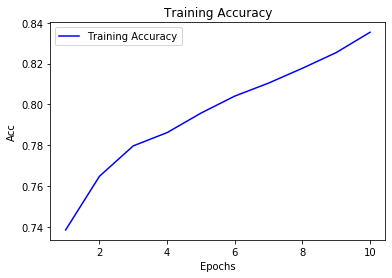

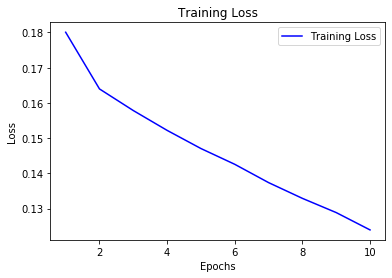

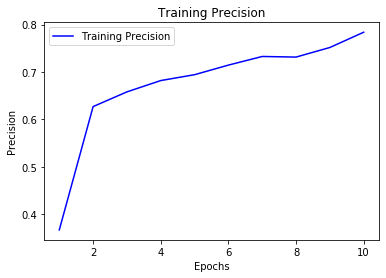

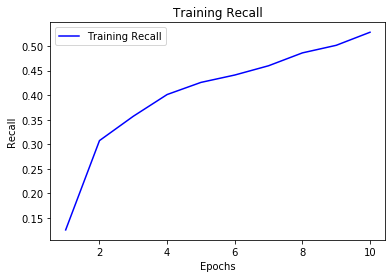

In [22]:
# %matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
# print(history_dict)
acc = history_dict['acc']
print("Final Acc:%s"%(acc[10-1]))
loss = history_dict['loss']
print("Final Loss:%s"%(loss[10-1]))
prec = history_dict['precision']
print("Final Precision:%s"%(prec[10-1]))
recall = history_dict['recall']
print("Final Recall:%s"%(recall[10-1]))


epochs = range(1, len(acc) + 1)
# val_acc = history_dict['val_acc']
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, prec, 'b', label='Training Precision')
plt.title('Training Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.plot(epochs, recall, 'b', label='Training Recall')
plt.title('Training Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [0]:
def get_LSTM_basic_model():
    tokens_embeddings_input = Input(shape=(None, embeddings_size,))
    lstm = Bidirectional(
        LSTM(
            units=128,
            dropout=args.dropout_rate,
            return_sequences=True,
            kernel_initializer='he_normal'
        )
    )(tokens_embeddings_input)

    lstm = Bidirectional(
        LSTM(
            units=128,
            dropout=args.dropout_rate,
            kernel_initializer='he_normal'
        )
    )(lstm)

    dense = Dropout(args.dropout_rate)(
        Dense(units=256, activation='relu', kernel_initializer='he_normal')(lstm)
    )
    dense = Dropout(args.dropout_rate)(
        Dense(units=128, activation='relu', kernel_initializer='he_normal')(dense)
    )

    output = Dense(units=1, activation='sigmoid', kernel_initializer='he_normal')(dense)

    model = Model(tokens_embeddings_input, output)

    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', f1])
    model.summary()


batch_size = 32
epochs = 100
print(x_train)
m = get_LSTM_basic_model()
m.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs)




In [0]:
class BertLayer(tf.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
DATA_ROOT = Path("..") / "input/sentiment-analysis-on-movie-reviews"
train = pd.read_csv(DATA_ROOT / 'train.tsv', sep="\t")
test = pd.read_csv(DATA_ROOT / 'test.tsv', sep="\t")

In [0]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}
    
model_type = 'roberta'

model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens
        
transformer_tokenizer = tokenizer_class.from_pretrained(model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [0]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]


pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [0]:
class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

In [0]:
config = config_class.from_pretrained(model_name)
config.num_labels = 5

transformer_model = model_class.from_pretrained(model_name, config = config)
# transformer_model = model_class.from_pretrained(model_name, num_labels = 5)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy])


list_layers = [learner.model.transformer.distilbert.embeddings,
               learner.model.transformer.distilbert.transformer.layer[0] ,
               learner.model.transformer.distilbert.transformer.layer[1],
               learner.model.transformer.distilbert.transformer.layer[2],
               learner.model.transformer.distilbert.transformer.layer[3],
               learner.model.transformer.distilbert.transformer.layer[4],
               learner.model.transformer.distilbert.transformer.layer[5],
               learner.model.transformer.pre_classifier]
               
learner.split(list_layers)